<a href="https://colab.research.google.com/github/Bustion11/NN-projects/blob/main/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(999)

In [ ]:
# First things first is the model
class Discriminator(nn.Module):
  '''
  Discriminator. 
    -Loss function in this case must be minimized.
    -Architecture details:
      -LeakyReLU for every layer.
      -BatchNormalization for every layer apart from input and output
      -No fully connected layers
  '''

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.LeakyReLU(negative_slope=self.relu_slope),
        nn.BatchNorm2d(out_channels)
    )

  def __init__(self, channels_img, features_d, relu_slope: float = 0.2):
    super(Discriminator, self).__init__()
    self.relu_slope = relu_slope

    self.stack = nn.Sequential(
        nn.Conv2d(channels_img, features_d*2, 4, 2, 1), # 1x28x28 -> 28x14x14, CHW
        nn.LeakyReLU(relu_slope),
        self._block(features_d*2, features_d*4, 4, 2, 1), # 28x14x14 -> 56x7x7
        self._block(features_d*4, features_d*8, 4, 2, 1), # 56x7x7 -> 112x3x3
        nn.Conv2d(features_d*8, 1, 3, 2, 0),
        nn.Sigmoid()
    )
    self.flat = nn.Flatten()
  
  def forward(self, X):
    x = self.stack(X)
    return self.flat(x)

Disc = Discriminator(1, 28).to(DEVICE)

In [ ]:
class Generator(nn.Module):

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )
  
  def __init__(self, channels_img, features_g, noise_dim=100):
    super(Generator, self).__init__()

    self.stack = nn.Sequential(
        # Input: Batch_size x noise_dim x 1 x 1
        self._block(noise_dim, features_g*16, 4, 2, 0), # 4x4
        self._block(features_g*16, features_g*8, 3, 2, 1), # 7x7
        self._block(features_g*8, features_g*4, 4, 2, 1), # 14x14
        nn.ConvTranspose2d(features_g*4, channels_img, 4, 2, 1), # 28x28
        nn.Tanh()
    )
  
  def forward(self, X):
    return self.stack(X)

Gen = Generator(1, 28).to(DEVICE)

In [ ]:
with torch.no_grad():
  print(Disc(torch.rand(128, 1, 28, 28).float()).shape)

In [ ]:
with torch.no_grad():
  print(Gen(torch.rand(128, 100, 1, 1).float()).shape)

In [ ]:
train_data = MNIST(
    root = "data",
    train = True, 
    transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5 for _ in range(1)], [0.5 for _ in range(1)])                                       
    ]),
    download=True
)

In [ ]:
batch_size = 128
lr_gen = 2e-4
lr_disc = 2e-4
betas = (0.5, 0.999)

disc_optimizer = torch.optim.Adam(Disc.parameters(), lr_disc, betas)
gen_optimizer = torch.optim.Adam(Gen.parameters(), lr_gen, betas)

loss_fn = nn.BCELoss()

In [ ]:
# Training discriminator
train_data_true = DataLoader(train_data, batch_size, shuffle=True)

In [ ]:
# Generate fixed noise for debugging purposes
fixed_noise = torch.randn(32, 100, 1, 1)

In [ ]:
def calculate_penalty(real, critic):
  real = torch.autograd.Variable(real, requires_grad=True)
  real_scores = critic(real)
  penalty = torch.autograd.grad(
        inputs=real,
        outputs=real_scores,
        grad_outputs=torch.ones_like(real_scores).to(DEVICE),
        create_graph=True,
        retain_graph=True
    )[0].reshape(real.shape[0], -1)

  penalty = torch.norm(penalty, dim=1).pow(2)
  return penalty.mean()

In [ ]:
# Training loop for classic CNN classificator
Disc.train()
Gen.train()
def GAN_training_loop(discriminator, generator, optimizer_discriminator, optimizer_generator, loss_function, dataloader, batch_size):
  for batch, (X, y) in enumerate(dataloader):
      X = X.to(DEVICE)
      real= X.to(DEVICE)
      noise = torch.randn(batch_size, 100, 1, 1).float().to(DEVICE)
      fake = generator(noise)
      
      # Use this formula to optimize discriminator: max log(D(X)) + log(1-D(G(z)))
      disc_real = discriminator(real).reshape(-1)
      disc_real_loss = loss_function(disc_real, torch.ones_like(disc_real))

      disc_fake = discriminator(fake).reshape(-1)
      disc_fake_loss = loss_function(disc_fake, torch.zeros_like(disc_fake))

      penalty = calculate_penalty(real.detach(), discriminator)

      disc_loss = (disc_real_loss + disc_fake_loss)/2 + 10/2 * penalty
      if batch % 100 == 0:
        print('Discriminator loss: ', disc_loss.detach())
        print(disc_real.shape)

      discriminator.zero_grad()
      disc_loss.backward(retain_graph=True)
      optimizer_discriminator.step()

      # Optimizing the generator

      output = discriminator(fake).reshape(-1)
      loss_generator = loss_function(output, torch.ones_like(output))
      if batch % 100 == 0:
        print('Generator loss: ', loss_generator.detach())
      
      generator.zero_grad()
      loss_generator.backward()
      optimizer_generator.step()

In [ ]:
GAN_training_loop(Disc, Gen, disc_optimizer, gen_optimizer, loss_fn, train_data_true, batch_size)

Discriminator loss:  tensor(0.6727, device='cuda:0')
torch.Size([128, 1])
Generator loss:  tensor(0.8143, device='cuda:0')
Discriminator loss:  tensor(0.6777, device='cuda:0')
torch.Size([128, 1])
Generator loss:  tensor(0.7604, device='cuda:0')
Discriminator loss:  tensor(0.6828, device='cuda:0')
torch.Size([128, 1])
Generator loss:  tensor(0.7412, device='cuda:0')
Discriminator loss:  tensor(0.6766, device='cuda:0')
torch.Size([128, 1])
Generator loss:  tensor(0.7725, device='cuda:0')
Discriminator loss:  tensor(0.6675, device='cuda:0')
torch.Size([128, 1])
Generator loss:  tensor(0.7952, device='cuda:0')


In [ ]:
for epoch in range(5):
  print("EPOCH #", epoch+1)
  GAN_training_loop(Disc, Gen, disc_optimizer, gen_optimizer, loss_fn, train_data_true, batch_size)

print("Finished!")
#torch.save(Disc.state_dict(), '/content/drive/MyDrive/NN/DCGAN/Disc_weights.pth')
#torch.save(Gen.state_dict(), '/content/drive/MyDrive/NN/DCGAN/Gen_weights.pth')
#torch.save(Disc, '/content/drive/MyDrive/NN/DCGAN/Disc.pth')
#torch.save(Gen, '/content/drive/MyDrive/NN/DCGAN/Gen.pth')

EPOCH # 1
Discriminator loss:  tensor(0.6277, device='cuda:0')
Generator loss:  tensor(0.8134, device='cuda:0')
Discriminator loss:  tensor(0.6180, device='cuda:0')
Generator loss:  tensor(0.8929, device='cuda:0')
Discriminator loss:  tensor(0.6379, device='cuda:0')
Generator loss:  tensor(0.8228, device='cuda:0')
Discriminator loss:  tensor(0.6212, device='cuda:0')
Generator loss:  tensor(0.8522, device='cuda:0')
Discriminator loss:  tensor(0.6402, device='cuda:0')
Generator loss:  tensor(0.8407, device='cuda:0')
EPOCH # 2
Discriminator loss:  tensor(0.6389, device='cuda:0')
Generator loss:  tensor(0.8618, device='cuda:0')
Discriminator loss:  tensor(0.6294, device='cuda:0')
Generator loss:  tensor(0.8212, device='cuda:0')
Discriminator loss:  tensor(0.6526, device='cuda:0')
Generator loss:  tensor(0.7853, device='cuda:0')
Discriminator loss:  tensor(0.6677, device='cuda:0')
Generator loss:  tensor(0.7976, device='cuda:0')
Discriminator loss:  tensor(0.6362, device='cuda:0')
Generator

In [ ]:
Gen.eval()
prediction = Gen(fixed_noise.to(DEVICE))

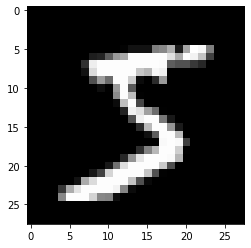

In [ ]:
plt.imshow(train_data.data[0], 'gray')

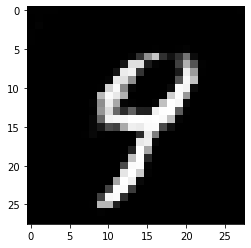

In [ ]:
plt.imshow(prediction.cpu().detach()[6][0], 'gray')
plt.show()